# Navnet 3

Learn depth representations and compare discrepencies in transformation of left image to right given the depth map and the transformations between the cameras. Based on Unsupervised CNN for single View Depth Estimattion.

In [1]:
import utils
import torch
import numpy as np
import matplotlib.pyplot as plt
train_path = "/home/michael/Desktop/BytesDB_train/"
test_path = "/home/michael/Desktop/BytesDB_test/"

## Using Pandas for Dataloading and Management, New Data Management Class

In [2]:
train_data =  utils.BytesDataset(train_path, crop=90)
test_data  =  utils.BytesDataset(test_path, crop=90)

## Batch Handling

In [3]:
import random

# returns right mask, right image, left mask, left image, path

def batch_generator(dataset, image_shape=(3,90,320), batch_size=16):
    while True:
        
        # create memory for training data
        
        left_images = torch.zeros((batch_size, image_shape[0], image_shape[1], image_shape[2]), requires_grad=True)
        right_images = torch.zeros((batch_size, image_shape[0], image_shape[1], image_shape[2]), requires_grad=True)
        
        i = 0
        while i < batch_size:
            
            rand_source = random.randint(0, len(dataset.data)-1)
            if dataset.index_exists(rand_source):
                left_images[i] = dataset.read_torch_image(rand_source)
                right_images[i] = dataset.read_torch_image(rand_source, right=True)
                
                i += 1
        yield right_images, left_images

In [4]:
right_images, left_images = next(batch_generator(train_data))

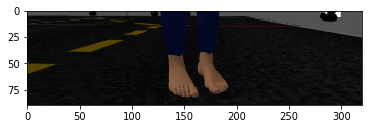

In [5]:
plt.imshow(utils.torch_image_to_cv_image(right_images[0].detach()))

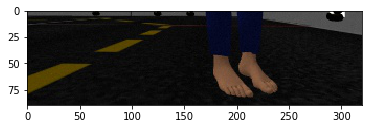

In [6]:
plt.imshow(utils.torch_image_to_cv_image(left_images[0].detach()))

## Create the autoencoder model

In [242]:
import torch.nn as nn

def same_padding(stride, width, height, filter_size):
    pad_w = ((stride-1)*width-stride+filter_size)/2
    pad_h = ((stride-1)*height-stride+filter_size)/2
    return (int(pad_h),int(pad_w))

class NavNet(nn.Module):
    def __init__(self, input_shape=(3, 90, 320)):
        super(NavNet, self).__init__()
        
        self.encoder = torch.nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=same_padding(1,input_shape[2],input_shape[1],5)),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=same_padding(1,input_shape[2]//2,input_shape[1]//2,5)),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=same_padding(1,input_shape[2]//2,input_shape[1]//2,5)),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.BatchNorm2d(128)
        )
        
        self.decoder = torch.nn.Sequential(
            nn.UpsamplingNearest2d((input_shape[1]//4, input_shape[2]//4)),
            nn.Conv2d(128, 64, kernel_size=5, stride=1, padding=same_padding(1,input_shape[2],input_shape[1],5)),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.UpsamplingNearest2d((input_shape[1]//2, input_shape[2]//2)),
            nn.Conv2d(64, 32, kernel_size=5, stride=1, padding=same_padding(1,input_shape[2],input_shape[1],5)),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.UpsamplingNearest2d((input_shape[1], input_shape[2])),
            nn.Conv2d(32, 32, kernel_size=5, stride=1, padding=same_padding(1,input_shape[2],input_shape[1],5)),
            nn.ReLU(),
            nn.Conv2d(32, 1, kernel_size=1, stride=1, padding=same_padding(1,input_shape[2],input_shape[1],1))
        )
    
    def forward(self, left_images):
        embedding = self.encoder(left_images)
        output = self.decoder(embedding)
        return output
    
def depth_loss(left_depth, left_images, right_images, focal_length=190.68, baseline=0.2, color_channels=3, device="cpu"):
    loss = 0
    for batch in range(left_depth.shape[0]):
        for y in range(left_depth.shape[1]):
            for x in range(left_depth.shape[2]):
                disp = torch.round(focal_length*baseline/left_depth[batch,y,x]).int()
                transformed_x = torch.max(torch.min(x - disp, torch.tensor(319, dtype=torch.int32).to(device)), torch.tensor(0, dtype=torch.int32).to(device))
                loss += (left_images[batch,:,y,x] - right_images[batch,:,y,transformed_x])**2
    loss /= (left_depth.shape[0]*left_depth.shape[1]*left_depth.shape[2])
    return loss.sum()/color_channels


In [243]:
navnet = NavNet()
pytorch_total_params = sum(p.numel() for p in navnet.parameters())
print("Model Size: ", pytorch_total_params)
output = navnet.forward(batch[0])
print(output.shape)

Model Size:  541025
torch.Size([16, 1, 90, 320])


In [245]:
left = train_data.read_torch_image(51).unsqueeze(0)
right = train_data.read_torch_image(51, right=True).unsqueeze(0)

left.requires_grad = True
right.requires_grad = True

output = navnet(left).squeeze(1)
# output = torch.ones((1,90,320), requires_grad=True)
loss = depth_loss(output, left, right)
print(loss)

tensor(0.0660, grad_fn=<DivBackward0>)


## Train the model

In [246]:
import torchvision

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

PyTorch Version:  1.5.0
Torchvision Version:  0.6.0
cuda:0


In [247]:
from IPython.display import clear_output

num_epochs = 40
train_steps_per_epoch = 1
test_steps_per_epoch = 1
batch_size = 1

collision_buffer = 35
path_length = 30

# Make Model
navnet = NavNet().to(device)
optimizer = torch.optim.Adam(navnet.parameters(), lr=1e-4)

train_batch_gen = batch_generator(train_data, batch_size=batch_size)
test_batch_gen = batch_generator(test_data, batch_size=batch_size)

train_loss = []
normal_test_loss = []

for epoch in range(num_epochs):
        
    # Train
    avg_train_loss = 0
    for step in range(train_steps_per_epoch):
        optimizer.zero_grad()
        
        right_images, left_images = next(train_batch_gen)
        output = navnet(left_images.to(device)).squeeze(1)
        loss = depth_loss(output, left_images.to(device), right_images.to(device), device="cuda")
        
        loss.backward()
        optimizer.step()
        avg_train_loss += loss.item()
        
    avg_train_loss /= train_steps_per_epoch
    train_loss.append(avg_train_loss)
    
    # Test
    avg_normal_test_loss = 0
    disp_output = None
    disp_input = None
    for step in range(test_steps_per_epoch):
        
        right_images, left_images = next(test_batch_gen)
        output = navnet(left_images.to(device)).squeeze(1)
        loss = depth_loss(output, left_images.to(device), right_images.to(device), device="cuda")
        
        avg_normal_test_loss += loss.item()
        
        # additional visualization ability
        disp_output = output
        disp_input = left_input
        
    avg_normal_test_loss /= test_steps_per_epoch
    normal_test_loss.append(avg_normal_test_loss)
    
    
    
    # Plot the losses in realtime
    clear_output(wait=True)
    
    fig = plt.figure(figsize=(40,10))
    fig.add_subplot(1,3,1)
    
    plt.plot(train_loss,  color='blue', label='train loss')
    plt.plot(test_loss,  color='green', label='test loss')

    fig.add_subplot(1,3,2)
    plt.imshow(utils.torch_image_to_cv_image(disp_input[0]))
    
    fig.add_subplot(1,3,3)
    plt.imshow(utils.torch_image_to_cv_image(disp_output[0].cpu().detach()))
    
    plt.show()
    
print(train_loss)
print("#########")
print(normal_test_loss)

True
True
True


RuntimeError: leaf variable has been moved into the graph interior

## Visualize the model

In [107]:
import time, cv2
import numpy as np

patch_side_len = 32
threshold = 0.032
crop_line = 90

navnet.eval()
for i in range(1, len(test_normal_data.data)):
    img = test_normal_data.read_torch_image(i)
    if len(img) > 0:
        cv_image = utils.torch_image_to_cv_image(img)

        image = img.unsqueeze(0).to(device)
        model_output = navnet(image)

        heat_map = ((image-model_output)**2).squeeze(0).cpu().detach().transpose(0,2).transpose(0,1).numpy()

        mask = np.sum(heat_map, axis=2)
        mask = (mask > threshold).astype(int)

        if loss > threshold:
            score = 1
        else:
            score = 0
            
        red = np.ones((cv_image.shape[0], cv_image.shape[1])) * mask
        green = np.ones((cv_image.shape[0], cv_image.shape[1])) * (1 - mask)
        color_mask = np.zeros(cv_image.shape)
        color_mask[:,:,0] = red
        color_mask[:,:,1] = green
        color_mask = (color_mask*255).astype('uint8')
        
        color_mask = cv2.medianBlur(color_mask,17)
        
        disp_image = cv2.addWeighted((cv_image*255).astype('uint8'),0.7,color_mask,0.3,0)  
        
        cv2.imshow('image', cv2.cvtColor(disp_image, cv2.COLOR_BGR2RGB))
        cv2.waitKey(50)

## Save the model

In [105]:
# Standard pytorch model saving/loading
name = "navnet-ae-full-predictor-v2.1-6-14-20"
torch.save(navnet.state_dict(), name + ".pt")
navnet.load_state_dict(torch.load(name + ".pt")) # test reloading model

<All keys matched successfully>

In [7]:
from torchvision import datasets, transforms


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Training dataset
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='.', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])), batch_size=64, shuffle=True, num_workers=4)
# Test dataset
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='.', train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=64, shuffle=True, num_workers=4)

In [14]:
import torch.nn as nn

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

        # Spatial transformer localization-network
        self.localization = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(10 * 3 * 3, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )

        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    # Spatial transformer network forward function
    def stn(self, x):
        xs = self.localization(x)
        print("xs: ", xs.shape)
        xs = xs.view(-1, 10 * 3 * 3)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)
        print(theta[0])
        print("theta: ", theta.shape)

        grid = F.affine_grid(theta, x.size())
        print("grid: ", grid.shape)
#         print(grid[0])
        x = F.grid_sample(x, grid)
        print("x transforemd: ", x.shape)

        return x

    def forward(self, x):
        print("x: ", x.shape)
        # transform the input
        x = self.stn(x)

        # Perform the usual forward pass
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


model = Net().to(device)

In [15]:
import torch.nn.functional as F
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)


def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 500 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
#
# A simple test procedure to measure STN the performances on MNIST.
#


def test():
    with torch.no_grad():
        model.eval()
        test_loss = 0
        correct = 0
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            # sum up batch loss
            test_loss += F.nll_loss(output, target, size_average=False).item()
            # get the index of the max log-probability
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
              .format(test_loss, correct, len(test_loader.dataset),
                      100. * correct / len(test_loader.dataset)))

In [16]:
train(0)

x:  torch.Size([64, 1, 28, 28])
xs:  torch.Size([64, 10, 3, 3])
tensor([[1., 0., 0.],
        [0., 1., 0.]], device='cuda:0', grad_fn=<SelectBackward>)
theta:  torch.Size([64, 2, 3])
grid:  torch.Size([64, 28, 28, 2])
x transforemd:  torch.Size([64, 1, 28, 28])
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.276924
x:  torch.Size([64, 1, 28, 28])
xs:  torch.Size([64, 10, 3, 3])
tensor([[ 9.9829e-01,  1.1261e-03, -7.9135e-03],
        [ 2.6930e-04,  1.0005e+00, -1.4403e-03]], device='cuda:0',
       grad_fn=<SelectBackward>)
theta:  torch.Size([64, 2, 3])
grid:  torch.Size([64, 28, 28, 2])
x transforemd:  torch.Size([64, 1, 28, 28])
x:  torch.Size([64, 1, 28, 28])
xs:  torch.Size([64, 10, 3, 3])
tensor([[ 9.9606e-01,  8.7011e-04, -7.7474e-03],
        [-1.1130e-03,  1.0004e+00,  2.8871e-03]], device='cuda:0',
       grad_fn=<SelectBackward>)
theta:  torch.Size([64, 2, 3])
grid:  torch.Size([64, 28, 28, 2])
x transforemd:  torch.Size([64, 1, 28, 28])
x:  torch.Size([64, 1, 28, 28])
xs:  torch.Size

/home/michael/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:3289: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/home/michael/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:3226: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


x:  torch.Size([64, 1, 28, 28])
xs:  torch.Size([64, 10, 3, 3])
tensor([[ 0.9815,  0.0053, -0.0275],
        [-0.0035,  0.9901,  0.0604]], device='cuda:0',
       grad_fn=<SelectBackward>)
theta:  torch.Size([64, 2, 3])
grid:  torch.Size([64, 28, 28, 2])
x transforemd:  torch.Size([64, 1, 28, 28])
x:  torch.Size([64, 1, 28, 28])
xs:  torch.Size([64, 10, 3, 3])
tensor([[ 0.9773,  0.0075, -0.0372],
        [-0.0034,  0.9866,  0.0809]], device='cuda:0',
       grad_fn=<SelectBackward>)
theta:  torch.Size([64, 2, 3])
grid:  torch.Size([64, 28, 28, 2])
x transforemd:  torch.Size([64, 1, 28, 28])
x:  torch.Size([64, 1, 28, 28])
xs:  torch.Size([64, 10, 3, 3])
tensor([[ 0.9846,  0.0051, -0.0310],
        [-0.0019,  0.9895,  0.0495]], device='cuda:0',
       grad_fn=<SelectBackward>)
theta:  torch.Size([64, 2, 3])
grid:  torch.Size([64, 28, 28, 2])
x transforemd:  torch.Size([64, 1, 28, 28])
x:  torch.Size([64, 1, 28, 28])
xs:  torch.Size([64, 10, 3, 3])
tensor([[ 0.9845,  0.0041, -0.0367],
  

KeyboardInterrupt: 

In [17]:
# Spatial transformer localization-network
localization = nn.Sequential(
    nn.Conv2d(1, 8, kernel_size=7),
    nn.MaxPool2d(2, stride=2),
    nn.ReLU(True),
    nn.Conv2d(8, 10, kernel_size=5),
    nn.MaxPool2d(2, stride=2),
    nn.ReLU(True)
)

In [18]:
localization(torch.zeros((1,1,28,28))).view(-1, 10 * 3 * 3).shape

torch.Size([1, 90])

In [19]:
fc_loc = nn.Sequential(
    nn.Linear(10 * 3 * 3, 32),
    nn.ReLU(True),
    nn.Linear(32, 3 * 2)
)

In [20]:
fc_loc(torch.zeros(1,90)).view(-1, 2, 3).shape

torch.Size([1, 2, 3])

In [21]:
print(right_images[0])

tensor([[[ 0.9132,  0.8618,  0.9646,  ...,  0.9132,  0.9132,  0.9132],
         [-0.2856, -0.3027, -0.2684,  ...,  0.0912,  0.1254,  0.1426],
         [-0.7137, -0.7137, -0.6965,  ..., -0.7993, -0.7479, -0.7308],
         ...,
         [-1.9295, -1.8953, -1.9295,  ..., -1.9809, -1.9638, -1.9809],
         [-1.9295, -1.8953, -1.9295,  ..., -1.9295, -1.8953, -1.9124],
         [-1.9467, -1.9295, -1.9638,  ..., -1.9124, -1.8953, -1.9124]],

        [[ 1.0630,  1.0105,  1.1155,  ...,  1.0630,  1.0630,  1.0630],
         [-0.1625, -0.1800, -0.1450,  ...,  0.2227,  0.2577,  0.2752],
         [-0.6001, -0.6001, -0.5826,  ..., -0.6877, -0.6352, -0.6176],
         ...,
         [-1.8431, -1.8081, -1.8431,  ..., -1.8957, -1.8782, -1.8957],
         [-1.8431, -1.8081, -1.8431,  ..., -1.8431, -1.8081, -1.8256],
         [-1.8606, -1.8431, -1.8782,  ..., -1.8256, -1.8081, -1.8256]],

        [[ 1.2805,  1.2282,  1.3328,  ...,  1.2805,  1.2805,  1.2805],
         [ 0.0605,  0.0431,  0.0779,  ...,  0

torch.Size([3, 90, 320])


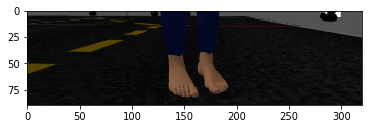

In [33]:
plt.imshow(utils.torch_image_to_cv_image(right_images[0].detach()))
print(right_images[0].shape)

torch.Size([1, 3, 90, 320])


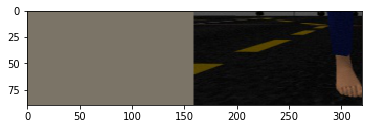

In [49]:
# flow_field = torch.zeros((1, 90, 320, 2))
# flow_field[:,:,:,0]= 0.01
# flow_field[:,:,:,1] = 0.01

# flow_field = torch.nn.functional.affine_grid(torch.tensor([[ 1.0,  0.0,  0.0], [0.0,  1.0,  0.0]]).unsqueeze(0), (1, 3, 90, 320))

x_base=torch.linspace(-1, 1, 320).repeat(1,90,1)
y_base=torch.linspace(-1, 1, 90).repeat(1, 320, 1).transpose(1, 2)
flow_field = torch.stack((x_base-1, y_base), dim=3)

# print(right_images[0])
transformed_image = F.grid_sample(right_images[0].unsqueeze(0), flow_field, align_corners=True)
print(transformed_image.shape) 
plt.imshow(utils.torch_image_to_cv_image(transformed_image.squeeze(0).detach()))
# print(transformed_image)

torch.Size([1, 3, 90, 320])


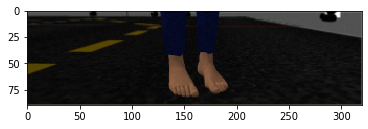

In [50]:
x_base=torch.linspace(-1, 1, 320).repeat(1,90,1)
y_base=torch.linspace(-1, 1, 90).repeat(1, 320, 1).transpose(1, 2)
flow_field = torch.stack((x_base, y_base), dim=3)

# print(right_images[0])
transformed_image = F.grid_sample(right_images[0].unsqueeze(0), flow_field, align_corners=False)
print(transformed_image.shape) 
plt.imshow(utils.torch_image_to_cv_image(transformed_image.squeeze(0).detach()))
# print(transformed_image)

In [37]:
def apply_disparity(self, img, disp, tensor_type='torch.cuda.FloatTensor'):
    batch_size, _, height, width = img.size()

    # Original coordinates of pixels
    x_base = torch.linspace(-1, 1, width).repeat(batch_size, height, 1).type(tensor_type)
    y_base = torch.linspace(-1, 1, height).repeat(batch_size, width, 1).transpose(1, 2).type(tensor_type)

    # Apply shift in X direction
    x_shifts = disp[:,0,:,:] # Disparity is passed in NCHW format with 1 channel
    flow_field = torch.stack((x_base + x_shifts, y_base), dim=3)
    output = F.grid_sample(img, flow_field, mode='bilinear', padding_mode='zeros', align_corners=False) # not sure the effect of align corners

    return output

In [38]:
x_base=torch.linspace(-1, 1, 320).repeat(1,180,1)
print(x_base.shape)
y_base=torch.linspace(-1, 1, 180).repeat(1, 320, 1).transpose(1, 2)
torch.stack((x_base, y_base), dim=3).shape

torch.Size([1, 180, 320])


torch.Size([1, 180, 320, 2])